In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import yfinance as yf
from scipy.stats import linregress

# ========== CONFIGURATION ==========
TICKER = "NVDA"  # Change this for different stocks
# ===================================


In [28]:
def get_stock_data(ticker):
    """Fetch and clean stock data from Yahoo Finance"""
    try:
        # Get raw stock data
        stock_data = yf.download(ticker, period="1y")
        
        # Fix multi-level columns
        stock_data.columns = ['_'.join(col).strip() for col in stock_data.columns.values]
        
        # Reset index and clean dates
        stock_data = stock_data.reset_index()
        stock_data['date'] = stock_data['Date'].dt.date
        stock_data.drop('Date', axis=1, inplace=True)
        
        return stock_data[['date', 'Close_' + ticker]]

    except Exception as e:
        print(f"❌ Error fetching stock data: {str(e)}")
        return None

In [29]:
def generate_daily_sentiment_csv(ticker):
    """Generate daily sentiment CSV from raw news data"""
    try:
        # Load raw news data
        input_path = f"{ticker}_news.csv"
        df = pd.read_csv(input_path)
        
        # Validate required columns
        if 'title' not in df.columns or 'publishedDate' not in df.columns:
            print(f"❌ CSV missing required columns: 'title' or 'publishedDate'")
            return False

        # Initialize sentiment analyzer
        analyzer = SentimentIntensityAnalyzer()
        
        # Calculate sentiment scores
        df['score'] = df['title'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
        
        # Clean and parse dates
        df['date'] = pd.to_datetime(df['publishedDate'], errors='coerce').dt.date
        df = df.dropna(subset=['date'])
        
        if df.empty:
            print("❌ No valid dates found after cleaning")
            return False

        # Aggregate daily sentiment
        daily_sentiment = df.groupby('date')['score'].mean().reset_index()
        
        # Export to CSV
        output_path = f"{ticker}_daily_sentiment.csv"
        daily_sentiment.to_csv(output_path, index=False)
        print(f"✅ Daily sentiment data saved to {output_path}")
        return True
        
    except FileNotFoundError:
        print(f"❌ Raw news file not found: {ticker}_news.csv")
        print("Please ensure you have the raw news CSV file first")
        return False
    except Exception as e:
        print(f"❌ Error generating sentiment CSV: {str(e)}")
        return False

def merge_sentiment_price(ticker=TICKER):
    """Main function to handle full pipeline"""
    try:
        # 1. Check for daily sentiment CSV
        try:
            sentiment_df = pd.read_csv(f"{ticker}_daily_sentiment.csv")
        except FileNotFoundError:
            print("⚠️ Daily sentiment CSV not found, generating now...")
            if not generate_daily_sentiment_csv(ticker):
                return None
            # Reload after generation
            sentiment_df = pd.read_csv(f"{ticker}_daily_sentiment.csv")

        # 2. Continue with existing merge process
        sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date
        
        # 3. Get stock data
        stock_df = get_stock_data(ticker)
        if stock_df is None:
            return None
            
        # 4. Merge datasets
        merged_df = pd.merge(sentiment_df, stock_df, on='date', how='inner')
        
        if merged_df.empty:
            print("❌ No overlapping dates between sentiment and price data")
            return None
            
        # 5. Format and export
        merged_df['date'] = merged_df['date'].astype(str)
        merged_df.columns = ['date', 'sentiment', 'stock_price']
        output_path = f"{ticker}_sentiment_price_merged.csv"
        merged_df.to_csv(output_path, index=False)
        
        print(f"✅ Successfully exported merged data to {output_path}")
        return merged_df.head()
        
    except Exception as e:
        print(f"❌ Unexpected error: {str(e)}")
        return None

    
# Run the full pipeline
if __name__ == "__main__":
    # 1. First ensure raw news data exists
    try:
        pd.read_csv(f"{TICKER}_news.csv")
    except FileNotFoundError:
        print(f"❌ Critical: Create {TICKER}_news.csv first with columns:")
        print("- title: News headline text")
        print("- publishedDate: Date in any format")
        exit()
    
    # 2. Run the full process
    result = merge_sentiment_price(TICKER)
    if result is not None:
        print(result)


[*********************100%***********************]  1 of 1 completed

⚠️ Daily sentiment CSV not found, generating now...
✅ Daily sentiment data saved to NVDA_daily_sentiment.csv
✅ Successfully exported merged data to NVDA_sentiment_price_merged.csv
         date  sentiment  stock_price
0  2025-05-02   0.134243   114.500000
1  2025-05-05   0.072756   113.820000
2  2025-05-06   0.093847   113.540001
3  2025-05-07   0.153060   117.059998
4  2025-05-08   0.165794   117.370003


📊 Loaded 26 days of NVDA data

📈 Statistical Analysis Results:
Pearson Correlation: 0.0752
R² Value: 0.0057
P-value: 0.7151


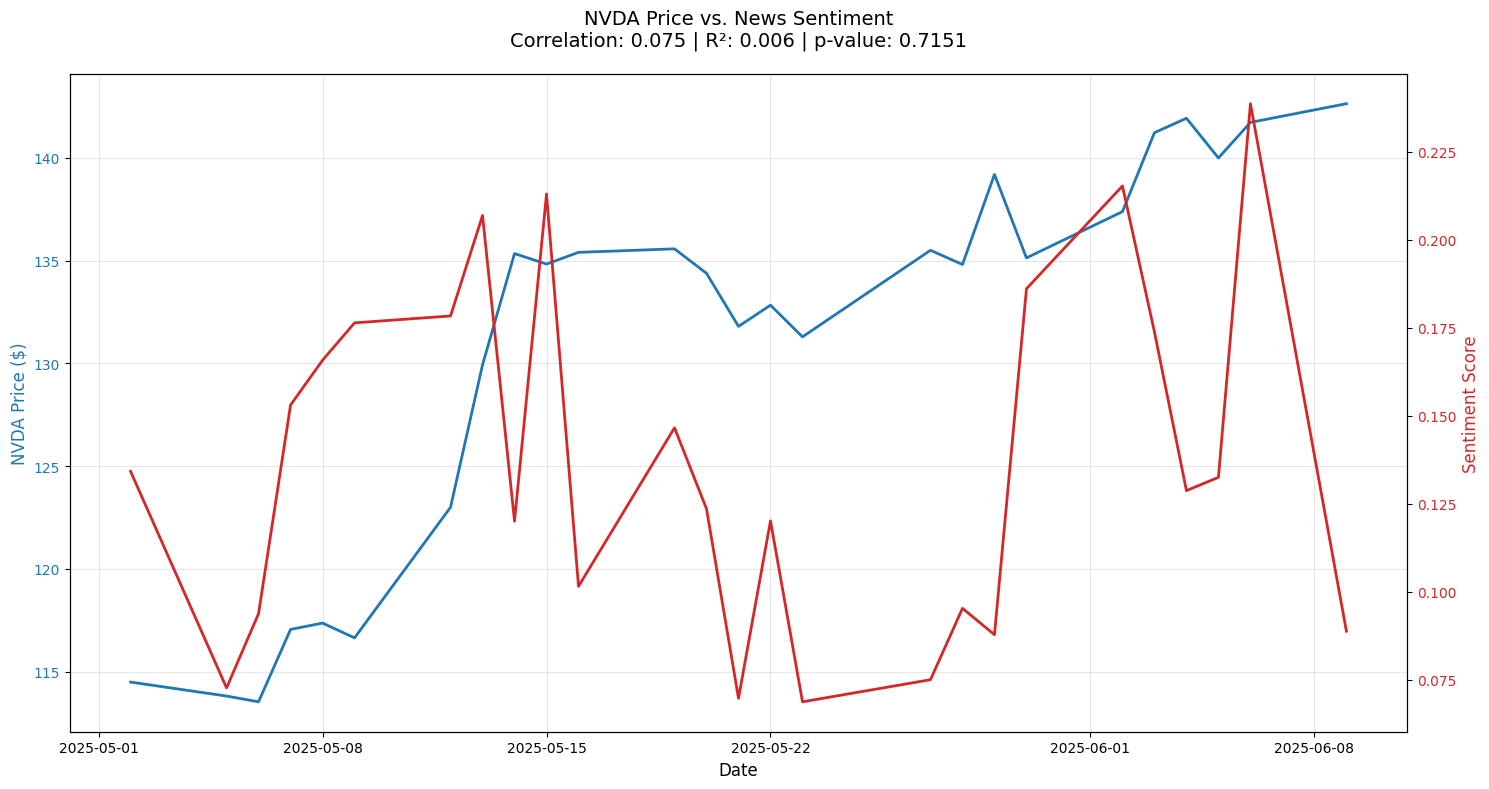


🔍 Interpretation:
Weak positive correlation between sentiment and price
❌ Not statistically significant (p >= 0.05)

📋 Sample of analyzed data:
        date  sentiment  stock_price
0 2025-05-02   0.134243   114.500000
1 2025-05-05   0.072756   113.820000
2 2025-05-06   0.093847   113.540001
3 2025-05-07   0.153060   117.059998
4 2025-05-08   0.165794   117.370003


In [30]:
def analyze_correlation_and_plot(ticker=TICKER):
    """Load merged data, calculate statistics, and create overlaid plot"""
    try:
        # 1. Load merged data
        merged_file = f"{ticker}_sentiment_price_merged.csv"
        df = pd.read_csv(merged_file)
        df['date'] = pd.to_datetime(df['date'])
        
        print(f"📊 Loaded {len(df)} days of {ticker} data")
        
        # 2. Calculate correlation statistics
        correlation = df['sentiment'].corr(df['stock_price'])
        slope, intercept, r_value, p_value, _ = linregress(df['sentiment'], df['stock_price'])
        r_squared = r_value ** 2
        
        print("\n📈 Statistical Analysis Results:")
        print(f"Pearson Correlation: {correlation:.4f}")
        print(f"R² Value: {r_squared:.4f}")
        print(f"P-value: {p_value:.4f}")
        
        # 3. Create dual-axis plot (like TSLA example)
        fig, ax1 = plt.subplots(figsize=(15, 8))
        
        # Plot stock price (blue line, left axis)
        ax1.plot(df['date'], df['stock_price'], color='#1f77b4', linewidth=2, label='Price')
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel(f'{ticker} Price ($)', color='#1f77b4', fontsize=12)
        ax1.tick_params(axis='y', labelcolor='#1f77b4')
        ax1.grid(True, alpha=0.3)
        
        # Create second y-axis for sentiment (red line, right axis)
        ax2 = ax1.twinx()
        ax2.plot(df['date'], df['sentiment'], color='#d62728', linewidth=2, label='Sentiment')
        ax2.set_ylabel('Sentiment Score', color='#d62728', fontsize=12)
        ax2.tick_params(axis='y', labelcolor='#d62728')
        
        # Title with correlation info
        plt.title(f'{ticker} Price vs. News Sentiment\nCorrelation: {correlation:.3f} | R²: {r_squared:.3f} | p-value: {p_value:.4f}', 
                 fontsize=14, pad=20)
        
        # Format x-axis
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # 4. Print interpretation
        print("\n🔍 Interpretation:")
        if abs(correlation) >= 0.7:
            strength = "Strong"
        elif abs(correlation) >= 0.3:
            strength = "Moderate"
        else:
            strength = "Weak"
            
        direction = "positive" if correlation > 0 else "negative"
        print(f"{strength} {direction} correlation between sentiment and price")
        
        if p_value < 0.05:
            print("✅ Statistically significant (p < 0.05)")
        else:
            print("❌ Not statistically significant (p >= 0.05)")
            
        return {
            'correlation': correlation,
            'r_squared': r_squared,
            'p_value': p_value,
            'data': df
        }
        
    except FileNotFoundError:
        print(f"❌ File not found: {ticker}_sentiment_price_merged.csv")
        print("Make sure you've run the merge step first!")
        return None
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        return None

# Run the analysis
if __name__ == "__main__":
    results = analyze_correlation_and_plot()
    
    if results:
        print(f"\n📋 Sample of analyzed data:")
        print(results['data'].head())


📈 Statistical Analysis Results (7-day MA):
Pearson Correlation: 0.1365
R² Value: 0.0186
P-value: 0.5062


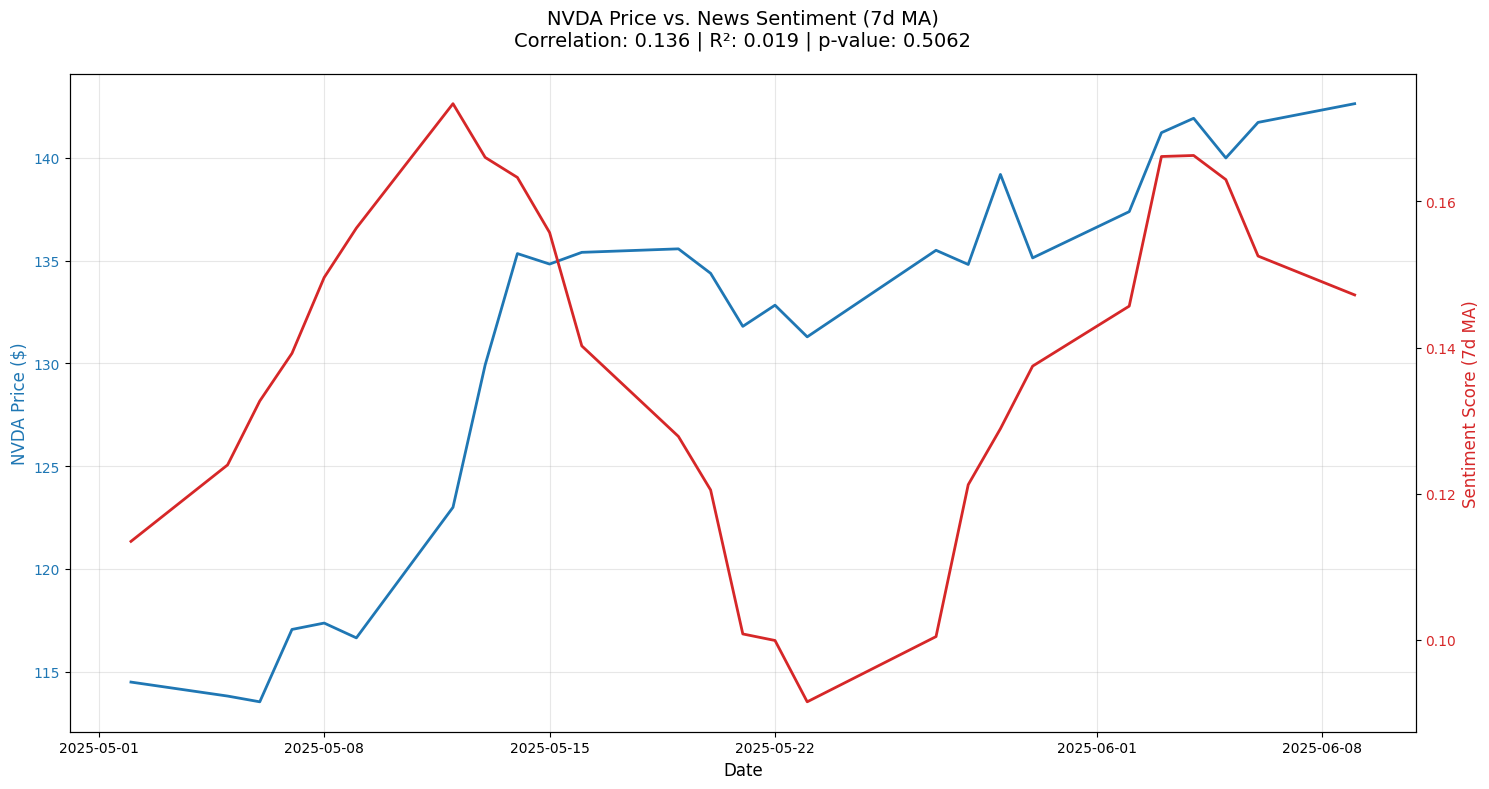

In [31]:
def analyze_correlation_and_plot(ticker=TICKER):
    df = pd.read_csv(f"{ticker}_sentiment_price_merged.csv")
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    
    # 7-day moving average for sentiment
    df['sentiment_ma7'] = df['sentiment'].rolling(window=7, min_periods=1, center=True).mean()
    
    # Correlation and regression using the smoothed sentiment
    correlation = df['sentiment_ma7'].corr(df['stock_price'])
    slope, intercept, r_value, p_value, _ = linregress(df['sentiment_ma7'], df['stock_price'])
    r_squared = r_value ** 2

    print("\n📈 Statistical Analysis Results (7-day MA):")
    print(f"Pearson Correlation: {correlation:.4f}")
    print(f"R² Value: {r_squared:.4f}")
    print(f"P-value: {p_value:.4f}")

    # Plot
    fig, ax1 = plt.subplots(figsize=(15, 8))
    ax1.plot(df['date'], df['stock_price'], color='#1f77b4', linewidth=2, label='Price')
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel(f'{ticker} Price ($)', color='#1f77b4', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='#1f77b4')
    ax1.grid(True, alpha=0.3)
    
    ax2 = ax1.twinx()
    ax2.plot(df['date'], df['sentiment_ma7'], color='#d62728', linewidth=2, label='Sentiment (7d MA)')
    ax2.set_ylabel('Sentiment Score (7d MA)', color='#d62728', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='#d62728')
    
    plt.title(f'{ticker} Price vs. News Sentiment (7d MA)\nCorrelation: {correlation:.3f} | R²: {r_squared:.3f} | p-value: {p_value:.4f}', 
              fontsize=14, pad=20)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Usage
if __name__ == "__main__":
    analyze_correlation_and_plot()

📊 Loaded 26 days of NVDA data for lag analysis

LAG CORRELATION INTERPRETATION GUIDE:
- Positive lag values mean SENTIMENT LEADING PRICE
  Example: Lag +5 = Today's sentiment vs. price 5 days later
- Negative lag values mean SENTIMENT FOLLOWING PRICE
  Example: Lag -5 = Today's sentiment vs. price 5 days earlier
- Lag 0 = Same-day correlation

🔍 Lag Correlation Analysis Results for NVDA:
--------------------------------------------------
Lag -30 days: nan (Sentiment follows price)
Lag -29 days: nan (Sentiment follows price)
Lag -28 days: nan (Sentiment follows price)
Lag -27 days: nan (Sentiment follows price)
Lag -26 days: nan (Sentiment follows price)
Lag -25 days: nan (Sentiment follows price)
Lag -24 days: 1.000 (Sentiment follows price)
Lag -23 days: 0.999 (Sentiment follows price)
Lag -22 days: -0.585 (Sentiment follows price)
Lag -21 days: -0.937 (Sentiment follows price)
Lag -20 days: -0.397 (Sentiment follows price)
Lag -19 days: -0.047 (Sentiment follows price)
Lag -18 days: 

/home/codespace/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/codespace/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/codespace/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


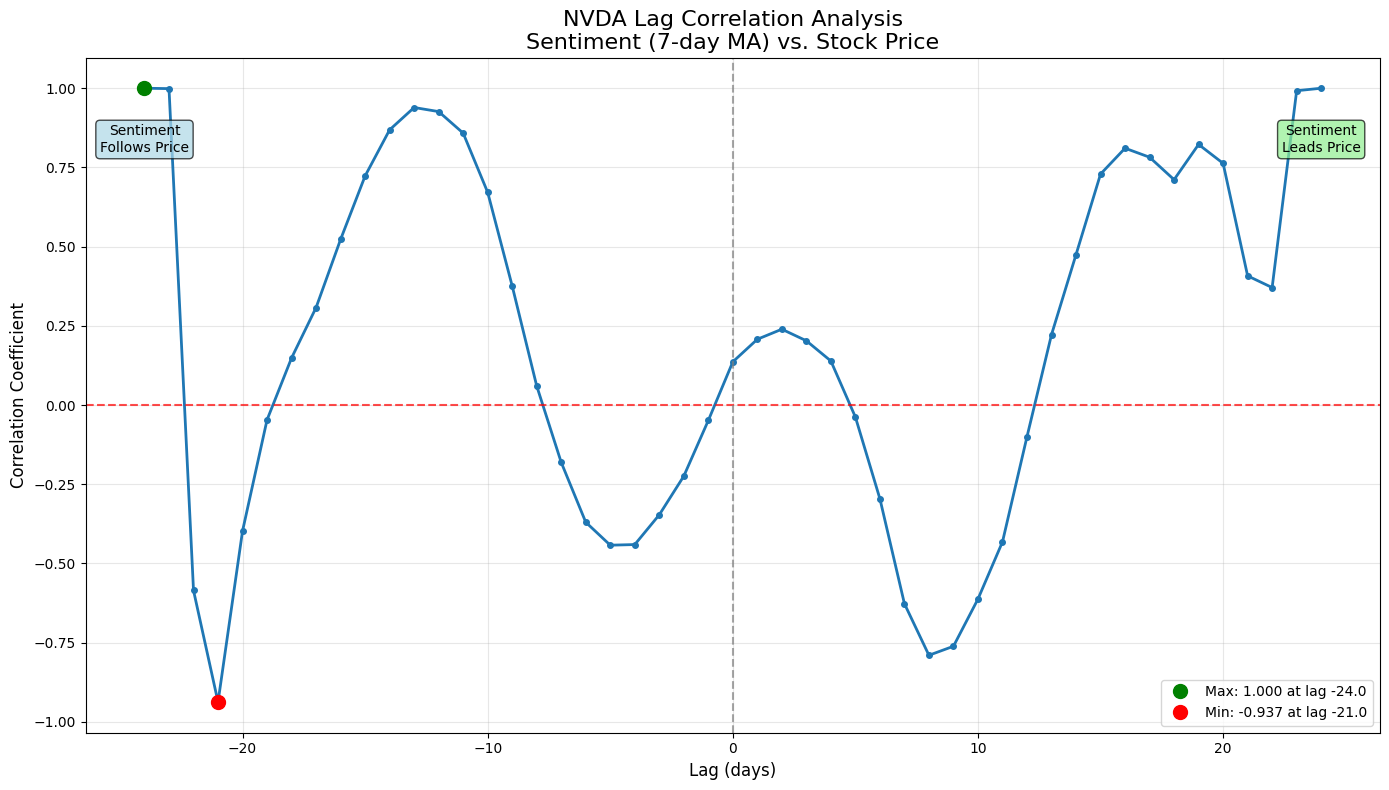


🔝 Top 5 Positive Correlations:
Lag -24.0 days: 1.000
Lag 24.0 days: 1.000
Lag -23.0 days: 0.999
Lag 23.0 days: 0.992
Lag -13.0 days: 0.939

🔻 Top 5 Negative Correlations:
Lag -21.0 days: -0.937
Lag 8.0 days: -0.790
Lag 9.0 days: -0.761
Lag 7.0 days: -0.627
Lag 10.0 days: -0.612


In [32]:
def perform_lag_analysis(ticker=TICKER, max_lag=30):
    """Perform lag correlation analysis between sentiment and stock price"""
    try:
        # Load merged data
        merged_file = f"{ticker}_sentiment_price_merged.csv"
        df = pd.read_csv(merged_file)
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date').reset_index(drop=True)
        
        print(f"📊 Loaded {len(df)} days of {ticker} data for lag analysis")
        
        # Apply 7-day moving average to sentiment for smoother analysis
        df['sentiment_ma7'] = df['sentiment'].rolling(window=7, min_periods=1, center=True).mean()
        
        # Lag analysis explanation
        print("\n" + "="*60)
        print("LAG CORRELATION INTERPRETATION GUIDE:")
        print("- Positive lag values mean SENTIMENT LEADING PRICE")
        print("  Example: Lag +5 = Today's sentiment vs. price 5 days later")
        print("- Negative lag values mean SENTIMENT FOLLOWING PRICE") 
        print("  Example: Lag -5 = Today's sentiment vs. price 5 days earlier")
        print("- Lag 0 = Same-day correlation")
        print("="*60 + "\n")
        
        # Perform lag analysis
        lag_results = []
        print(f"🔍 Lag Correlation Analysis Results for {ticker}:")
        print("-" * 50)
        
        for lag in range(-max_lag, max_lag + 1):
            # Shift sentiment data by lag days
            shifted_sentiment = df['sentiment_ma7'].shift(lag)
            
            # Calculate correlation with stock price
            lag_corr = df['stock_price'].corr(shifted_sentiment)
            
            # Store results
            lag_results.append({'lag': lag, 'correlation': lag_corr})
            
            # Add interpretation suffix
            if lag > 0:
                interpretation = "(Sentiment leads price)"
            elif lag < 0:
                interpretation = "(Sentiment follows price)"
            else:
                interpretation = "(Same day)"
                
            print(f"Lag {lag:3} days: {lag_corr:.3f} {interpretation}")
        
        # Convert to DataFrame for analysis
        lag_df = pd.DataFrame(lag_results)
        
        # Find best correlations
        best_positive_lag = lag_df.loc[lag_df['correlation'].idxmax()]
        best_negative_corr = lag_df.loc[lag_df['correlation'].idxmin()]
        
        print(f"\n📈 SUMMARY:")
        print(f"Best positive correlation: {best_positive_lag['correlation']:.3f} at lag {best_positive_lag['lag']} days")
        print(f"Best negative correlation: {best_negative_corr['correlation']:.3f} at lag {best_negative_corr['lag']} days")
        
        # Create visualization
        plt.figure(figsize=(14, 8))
        plt.plot(lag_df['lag'], lag_df['correlation'], marker='o', linewidth=2, markersize=4)
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
        
        # Highlight best correlations
        plt.plot(best_positive_lag['lag'], best_positive_lag['correlation'], 
                'go', markersize=10, label=f'Max: {best_positive_lag["correlation"]:.3f} at lag {best_positive_lag["lag"]}')
        plt.plot(best_negative_corr['lag'], best_negative_corr['correlation'], 
                'ro', markersize=10, label=f'Min: {best_negative_corr["correlation"]:.3f} at lag {best_negative_corr["lag"]}')
        
        plt.title(f'{ticker} Lag Correlation Analysis\nSentiment (7-day MA) vs. Stock Price', fontsize=16)
        plt.xlabel('Lag (days)', fontsize=12)
        plt.ylabel('Correlation Coefficient', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Add interpretation zones
        plt.text(-max_lag*0.8, 0.8, 'Sentiment\nFollows Price', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7),
                horizontalalignment='center', fontsize=10)
        plt.text(max_lag*0.8, 0.8, 'Sentiment\nLeads Price', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7),
                horizontalalignment='center', fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        return lag_df
        
    except FileNotFoundError:
        print(f"❌ File not found: {ticker}_sentiment_price_merged.csv")
        print("Make sure you've run the merge step first!")
        return None
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        return None

# Run lag analysis
if __name__ == "__main__":
    lag_results = perform_lag_analysis()
    
    if lag_results is not None:
        # Show top 5 positive and negative correlations
        print("\n🔝 Top 5 Positive Correlations:")
        top_positive = lag_results.nlargest(5, 'correlation')
        for _, row in top_positive.iterrows():
            print(f"Lag {row['lag']:3} days: {row['correlation']:.3f}")
            
        print("\n🔻 Top 5 Negative Correlations:")
        top_negative = lag_results.nsmallest(5, 'correlation')
        for _, row in top_negative.iterrows():
            print(f"Lag {row['lag']:3} days: {row['correlation']:.3f}")

📊 Loaded 26 days of NVDA data

🔍 Finding optimal lag...
✅ Optimal lag found: -23 days (correlation: 0.999)

📈 Lagged Correlation Analysis Results (Lag: -23 days):
Pearson Correlation: 0.9987
R² Value: 0.9975
P-value: 0.0320


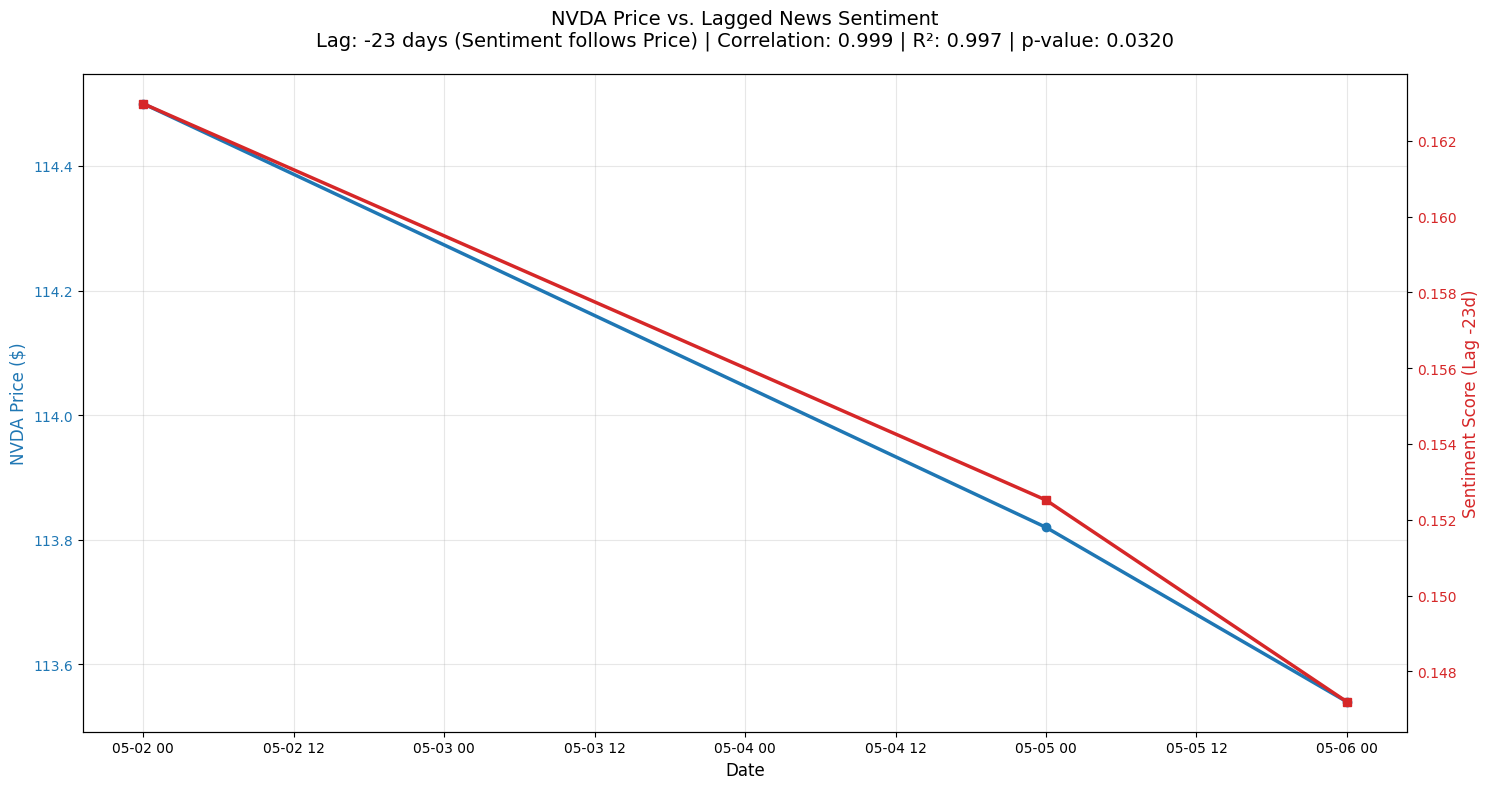


🔍 Interpretation:
📉 Sentiment FOLLOWS price by 23 days
   → News sentiment reacts to past price movements
✅ Statistically significant (p < 0.05)
💪 Strong correlation detected

📋 Final Results Summary:
Optimal Lag: -23 days
Lagged Correlation: 0.9987
R² Value: 0.9975
P-value: 0.0320


In [33]:
def find_optimal_lag_and_plot(ticker=TICKER, max_lag=30):
    """Find optimal lag and create lagged correlation analysis"""
    try:
        # 1. Load merged data
        merged_file = f"{ticker}_sentiment_price_merged.csv"
        df = pd.read_csv(merged_file)
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date').reset_index(drop=True)
        
        print(f"📊 Loaded {len(df)} days of {ticker} data")
        
        # 2. Apply 7-day moving average to sentiment
        df['sentiment_ma7'] = df['sentiment'].rolling(window=min(7, len(df)), min_periods=1, center=True).mean()
        
        # 3. Perform lag analysis to find optimal lag
        print("\n🔍 Finding optimal lag...")
        lag_results = []
        
        for lag in range(-max_lag, max_lag + 1):
            # Shift sentiment data by lag days
            shifted_sentiment = df['sentiment_ma7'].shift(lag)
            
            # Calculate correlation with stock price (only valid overlapping data)
            valid_mask = ~(shifted_sentiment.isna() | df['stock_price'].isna())
            if valid_mask.sum() > 2:  # Need at least 3 points for correlation
                lag_corr = df.loc[valid_mask, 'stock_price'].corr(shifted_sentiment[valid_mask])
                lag_results.append({'lag': lag, 'correlation': lag_corr})
        
        # Convert to DataFrame and find best positive correlation
        lag_df = pd.DataFrame(lag_results)
        best_positive = lag_df[lag_df['correlation'] > 0].sort_values('correlation', ascending=False)
        
        if best_positive.empty:
            print("❌ No positive correlations found, using lag 0")
            optimal_lag = 0
            optimal_corr = lag_df[lag_df['lag'] == 0]['correlation'].iloc[0]
        else:
            optimal_lag = int(best_positive.iloc[0]['lag'])
            optimal_corr = best_positive.iloc[0]['correlation']
        
        print(f"✅ Optimal lag found: {optimal_lag} days (correlation: {optimal_corr:.3f})")
        
        # 4. Apply optimal lag and calculate statistics
        df['sentiment_lagged'] = df['sentiment_ma7'].shift(optimal_lag)
        
        # Remove NaN values created by shifting
        analysis_df = df.dropna(subset=['sentiment_lagged', 'stock_price']).copy()
        
        if len(analysis_df) < 3:
            print("❌ Insufficient data after applying lag")
            return None
        
        # Calculate enhanced statistics
        correlation = analysis_df['sentiment_lagged'].corr(analysis_df['stock_price'])
        slope, intercept, r_value, p_value, _ = linregress(analysis_df['sentiment_lagged'], analysis_df['stock_price'])
        r_squared = r_value ** 2
        
        print(f"\n📈 Lagged Correlation Analysis Results (Lag: {optimal_lag} days):")
        print(f"Pearson Correlation: {correlation:.4f}")
        print(f"R² Value: {r_squared:.4f}")
        print(f"P-value: {p_value:.4f}")
        
        # 5. Create visualization
        fig, ax1 = plt.subplots(figsize=(15, 8))
        
        # Plot stock price (blue line, left axis)
        ax1.plot(analysis_df['date'], analysis_df['stock_price'], 
                color='#1f77b4', linewidth=2.5, marker='o', markersize=6, label='Price')
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel(f'{ticker} Price ($)', color='#1f77b4', fontsize=12)
        ax1.tick_params(axis='y', labelcolor='#1f77b4')
        ax1.grid(True, alpha=0.3)
        
        # Create second y-axis for lagged sentiment (red line, right axis)
        ax2 = ax1.twinx()
        ax2.plot(analysis_df['date'], analysis_df['sentiment_lagged'], 
                color='#d62728', linewidth=2.5, marker='s', markersize=6, 
                label=f'Sentiment (Lag {optimal_lag}d)')
        ax2.set_ylabel(f'Sentiment Score (Lag {optimal_lag}d)', color='#d62728', fontsize=12)
        ax2.tick_params(axis='y', labelcolor='#d62728')
        
        # Enhanced title with all statistics
        lag_direction = "leads" if optimal_lag > 0 else "follows" if optimal_lag < 0 else "same-day"
        plt.title(f'{ticker} Price vs. Lagged News Sentiment\n'
                 f'Lag: {optimal_lag} days (Sentiment {lag_direction} Price) | '
                 f'Correlation: {correlation:.3f} | R²: {r_squared:.3f} | p-value: {p_value:.4f}', 
                 fontsize=14, pad=20)
        
        # Format dates and layout
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # 6. Print interpretation
        print(f"\n🔍 Interpretation:")
        if optimal_lag > 0:
            print(f"📈 Sentiment LEADS price by {optimal_lag} days")
            print("   → News sentiment predicts future price movements")
        elif optimal_lag < 0:
            print(f"📉 Sentiment FOLLOWS price by {abs(optimal_lag)} days")
            print("   → News sentiment reacts to past price movements")
        else:
            print("📊 Same-day relationship")
            print("   → News sentiment and price move together")
        
        # Statistical significance
        if p_value < 0.01:
            print("✅ Highly statistically significant (p < 0.01)")
        elif p_value < 0.05:
            print("✅ Statistically significant (p < 0.05)")
        else:
            print("❌ Not statistically significant (p >= 0.05)")
        
        # Correlation strength
        if abs(correlation) >= 0.7:
            strength = "Strong"
        elif abs(correlation) >= 0.3:
            strength = "Moderate"
        else:
            strength = "Weak"
        print(f"💪 {strength} correlation detected")
        
        return {
            'optimal_lag': optimal_lag,
            'correlation': correlation,
            'r_squared': r_squared,
            'p_value': p_value,
            'data': analysis_df
        }
        
    except FileNotFoundError:
        print(f"❌ File not found: {ticker}_sentiment_price_merged.csv")
        return None
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        return None

# Run the lagged analysis
if __name__ == "__main__":
    results = find_optimal_lag_and_plot()
    
    if results:
        print(f"\n📋 Final Results Summary:")
        print(f"Optimal Lag: {results['optimal_lag']} days")
        print(f"Lagged Correlation: {results['correlation']:.4f}")
        print(f"R² Value: {results['r_squared']:.4f}")
        print(f"P-value: {results['p_value']:.4f}")